In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llmdata/sample_submission.csv
/kaggle/input/llmdata/train_prompts.csv
/kaggle/input/llmdata/test_essays.csv
/kaggle/input/llmdata/train_essays.csv/train_essays.csv
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/saved_model.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/keras_metadata.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/assets/vocab.txt
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.index
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.data-00000-of-00001


In [44]:
import numpy as np
import pandas as pd
import imblearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Input,Dropout
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
train_prompts = pd.read_csv('/kaggle/input/llmdata/train_prompts.csv')
train_essay = pd.read_csv('/kaggle/input/llmdata/train_essays.csv/train_essays.csv')

In [46]:
train_prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [47]:
train_essay.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [48]:
train_essay.shape

(1378, 4)

In [49]:
train_essay['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

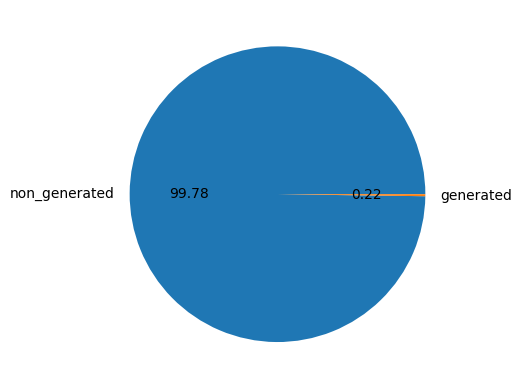

In [50]:
plt.pie(train_essay['generated'].value_counts(),labels = ['non_generated','generated'],autopct="%0.2f")
plt.show()

In [51]:
train_essay.isnull().value_counts()

id     prompt_id  text   generated
False  False      False  False        1378
Name: count, dtype: int64

In [56]:
train_text = pd.DataFrame(train_essay['text'])
train_generated = pd.DataFrame(train_essay['generated'])

In [57]:
print(train_text.shape,train_generated.shape)

(1378, 1) (1378, 1)


In [58]:
df_text = train_text
df_generated = train_generated

In [59]:
print(df_text.shape,df_generated.shape)

(1378, 1) (1378, 1)


In [60]:
labels = ['non_generated','generated']

In [61]:
df_generated['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

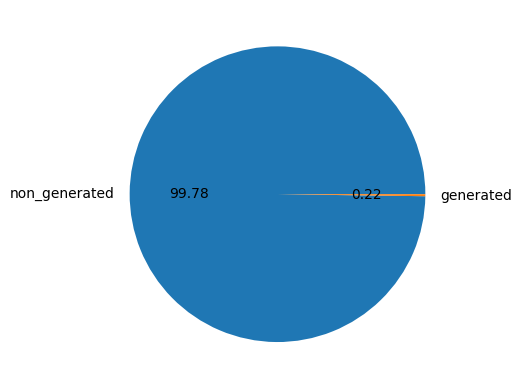

In [62]:
plt.pie(df_generated['generated'].value_counts(),labels = labels,autopct="%0.2f")
plt.show()

In [63]:
import nltk

In [64]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [65]:
df_text['num_charachters'] = df_text['text'].apply(len)
df_text['num_words'] = df_text['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df_text['num_sentences'] = df_text['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [66]:
#text by human
df_text[df_generated['generated'] == 0][['num_charachters','num_words','num_sentences']].describe()

,num_charachters,num_words,num_sentences
count,1375.000000,1375.000000,1375.000000
mean,3172.581091,622.440000,27.658182
std,918.439217,179.430461,8.713595
min,1486.000000,299.000000,7.000000
25%,2556.500000,498.000000,22.000000
50%,2987.000000,586.000000,27.000000
75%,3624.500000,716.500000,32.000000
max,8436.000000,1515.000000,70.000000


In [67]:
#text by NLM
df_text[df_generated['generated'] == 1][['num_charachters','num_words','num_sentences']].describe()

,num_charachters,num_words,num_sentences
count,3.000000,3.000000,3.000000
mean,1551.000000,283.666667,12.333333
std,224.879968,29.535290,2.309401
min,1356.000000,255.000000,11.000000
25%,1428.000000,268.500000,11.000000
50%,1500.000000,282.000000,11.000000
75%,1648.500000,298.000000,13.000000
max,1797.000000,314.000000,15.000000


In [68]:
#model training


In [69]:
X = df_text['text']
y = df_generated['generated']

In [70]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,shuffle = True)

In [71]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(826,) (552,) (826,) (552,)


In [72]:
#importing BERT APIS 
bert_preprocess = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...


In [73]:
#bert layers
text_input = Input(shape =(),dtype = tf.string)
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [74]:
#neural network layers
x = Dropout(rate = 0.1)(outputs['pooled_output'])
y = Dense(1,activation = 'sigmoid')(x)

model = Model(inputs = [text_input],outputs = [y])

In [75]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_word_ids': (None,    0         ['input_2[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [76]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name = "accuracy"),
    tf.keras.metrics.Precision(name = "precision"),
    tf.keras.metrics.Recall(name = "recall")
]

model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = METRICS)

In [77]:
model.fit(X_train,y_train,epochs = 5,batch_size = 64)

Epoch 1/5
13/13 [==============================] - 223s 16s/step - loss: 0.2027 - accuracy: 0.9479 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 212s 16s/step - loss: 0.0139 - accuracy: 0.9988 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/5
13/13 [==============================] - 211s 16s/step - loss: 0.0083 - accuracy: 0.9988 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/5
13/13 [==============================] - 211s 16s/step - loss: 0.0068 - accuracy: 0.9988 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/5
13/13 [==============================] - 213s 16s/step - loss: 0.0065 - accuracy: 0.9988 - precision: 0.0000e+00 - recall: 0.0000e+00
